In [1]:
#
# Importing the necessary libraries: 
# NumPy, SciPy (spatial algorithms), timing functions, a handler for csv files 
#
import numpy as np
import scipy.spatial as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import time
import csv
from numba import jit

In [2]:
#
# Centering a point cloud A
#
@jit(target_backend='mps')
#
def barycentered(A):
    #
    bar = np.sum(A, axis=1)/A.shape[1]
    #
    return A - bar[:, np.newaxis]

In [3]:
#
# Best orthogonal fit between two (centred) labelled point clouds
# A and B are assumed to have the same number of points
#
@jit(target_backend='mps')
#
def best_fit(A, B):
    #
    na = A.shape[1]
    nb = B.shape[1]
    #
    assert na==nb
    #
    H = A @ B.T
    W, S, V = np.linalg.svd(H)
    #
    return V.T @ W.T

In [4]:
#
# Detecting nearest neighbours between two unlabelled point coluds A and B
#
# Assumption: cardinality of A <= cardinality of B 
#
# Input: point clouds A, B
#
# Output: for each point of A a matching point of B, as a 0/1-matrix
#
@jit(target_backend='mps')
#
def nearest_neighbours(A, B):
    #
    na = A.shape[1]
    nb = B.shape[1]
    #
    assert na <= nb
    #
    tree = sp.KDTree(A.T, leafsize=10, compact_nodes=True, copy_data=True, balanced_tree=True)
    #
    matching = []
    I = matrix.identity(na)
    #
    for i in range(nb):
        _, ind = tree.query(B.T[i], k=1, p=2, workers=-1)
        matching += [I[ind]]
    #    
    return np.array(matching)

In [5]:
#
# ICP algorithm for two unlabelled point clouds A and B
#
# Assumption: cardinality of A <= cardinality of B
#
# Input:
# A, B = unlabelled point clouds
# init = initial orthogonal transformation
# max_iter = maximum number of iterations
# tol = tolerance for halting the computation
#
# Output:
# U = orthogonal transformation bringing A to B as close as possible
# nn = nearest neighbor matching between U*A and B
# dist = distance between U*A and B*nn (in the max singular value norm)
#
@jit(target_backend='mps')
#
def icp(A, B, init=None, max_iter=100, tol=1e-16):
    #
    src = copy(A)
    dst = copy(B)
    #
    na = src.shape[1]
    nb = src.shape[1]
    #
    assert na <= nb
    #
    if (init is not None):
        src = init @ src
    #    
    prev_err = 0
    #
    for i in range(max_iter):
        #   
        nn = nearest_neighbours(src, dst)
        U = best_fit(src, dst @ nn)
        #    
        src = U @ src
        #
        diff = src - dst @ nn
        err  = np.linalg.norm(diff, 2)
        #
        if abs(prev_err - err) < tol:
            break
        #    
        prev_err = err
    #
    U = best_fit(A, src)
    nn = nearest_neighbours(U @ A, dst)
    #
    diff = U @ A - B @ nn
    dist = np.linalg.norm(diff, 2)
    #
    return U, nn, dist

In [6]:
#
# Testing the Main Algorithm on occluded point clouds 
#
# We use the unoccluded version of the Caerbannog Point Clouds
# and produce the occlusing points on our own: this allows us
# to easily control the level of occlusion
#
# Occluding points are uniformly represented within the bounding
# box of the initial unoccluded image
#

In [7]:
#
# Raghupathi, Sunand; Brunhart-Lupo, Nicholas; Gruchalla, Kenny (2020)
# "Caerbannog Point Clouds". National Renewable Energy Laboratory. 10.7799/1729892
# Source: https://data.nrel.gov/submissions/153
#

In [8]:
#
# Testing the Algorithm on point clouds with different levels of occlusion, 
# additive and multiplicative noise superimposed.
#
# Input: an unoccluded point cloud P, occlusion level, 
#        additive noise level, multiplicative noise level  
#
# Producing another point cloud Q0 = O * P * S, with O a random orthogonal transformation
# and S a random permutation. Then adding noise and some extra occlusion points X to Q0 in 
# order to obtain a new *noisy and occluded* point cloud Q.  
#
# Test: determine the distance dist_spec from the recovered image of P denoted by 
# R = o * P * S to the specimen Q0, and compare it to the distance between d_icp between 
# o * P * s and Q returned by the ICP algorithm.
#
# Here it is important to note that S is a permutation, while s is a matching of nearest 
# neighbours in o * P and Q. The latter does not have to be a permutation matrix. 
#
@jit(target_backend='mps')
#
# key function for sorting solutions (jit global name requirement)
#
def key(x):
    return x[2]
#
# test_point_cloud GPU speed-up
#
def test_point_cloud(P, level=0.1, sigma_add=0.01, sigma_mul=0.05, tol=0.05, verbose=False):
    #
    dim = P.shape[0]
    num = P.shape[1]
    occ = int(num * level)
    normP = np.linalg.norm(P, 2)
    if verbose:
        print("Number of genuine points:   {}".format(num))
        print("Number of occlusion points: {}".format(occ))
    #
    seed = np.random.normal(0.0, 1.0, (dim, dim))
    O = np.linalg.qr(seed, mode='complete')[0]
    #
    S = np.random.default_rng().permutation(np.identity(num+occ))
    #
    P = barycentered(P)
    #
    Q0 = O @ P
    N_add = np.random.normal(0.0, sigma_add, (dim, num))
    N_mul = np.random.normal(1.0, sigma_mul, (dim, num))
    Q = Q0 + N_add
    Q = N_mul * Q
    #
    X  = [np.random.uniform(np.min(P[i,:]), np.max(P[i,:]), occ) for i in range(dim)]
    X  = np.array(X)
    X  = O @ X
    #
    dist_err = np.linalg.norm(Q - Q0, 2) + np.linalg.norm(X, 2)
    dist_err = dist_err / normP
    if verbose:
        print("Total error introduced (normalised): {}".format(dist_err))
    #
    Q = np.c_[Q, X]
    Q = Q @ S
    Q = barycentered(Q)
    #
    Ep = P @ P.T
    Eigp, Up = np.linalg.eigh(Ep)
    #
    Eq = Q @ Q.T
    Eigq, Uq = np.linalg.eigh(Eq)
    #
    U0 = Uq @ Up.T
    #
    isoms_discrete = MatrixGroup([matrix.diagonal(d) for d in Permutations([-1]+[1]*(dim-1))])
    isoms_discrete = [np.array(matrix(m)) for m in isoms_discrete]
    #
    sols = []
    for isom in isoms_discrete:
        U = U0 @ Up @ isom @ Up.T
        nn = nearest_neighbours(U @ P, Q)
        diff_init = U @ P - Q @ nn
        d_init = np.linalg.norm(diff_init, 2) / normP
        sols += [(U, nn, d_init)]
    sols = sorted(sols, key=key)
    o_init, s_init, dist_init = sols[0]
    o, s, d = icp(P, Q, o_init)
    dist_icp = d / normP
    delta_icp = dist_init - dist_icp
    diff = o_init - o
    delta_ortho_icp = np.linalg.norm(diff, 2)
    R = o @ P
    diff = Q0 - R
    dist_spec = np.linalg.norm(diff, 2) / normP
    diff = o - O
    dist_ortho = np.linalg.norm(diff, 2)
    if verbose:
        print("Orthogonal transformation found:")
        print(o)
        print("Distance to the initial one:")
        print(dist_ortho)
        print("Normalised distance to occluded image:")
        print(dist_icp)
        print("Actual distance to specimen (normalised):")
        print(dist_spec)
        print("ICP improvement (normalised):")
        print(delta_icp)
        print("ICP change to orthogonal transformation:")
        print(delta_ortho_icp)
    #
    flag = ( dist_spec < tol )
    #
    return flag, dist_err, dist_icp, delta_icp, delta_ortho_icp, dist_spec, dist_ortho

In [9]:
#
# Running a given number of tests num_tests on a given point cloud 
# generated by calling test_point_cloud(P, level, tol, verbose)
#
# Some statistics is collected and printed as output
#
@jit(target_backend='mps')
#
def run_tests_point_cloud(P, num_tests, level=0.1, sigma_add=0.01, sigma_mul=0.05, tol=0.05, verbose=False):
    #
    num_success = 0
    num_fail  = 0
    rec_dist_noise = []
    rec_dist_icp = []
    rec_delta_icp = []
    rec_delta_ortho_icp = []
    rec_dist_spec = []
    rec_dist_ortho = []
    #
    start = time.process_time()
    #
    for i in range(num_tests):
        #
        msg = '### Test #{} : '.format(i+1)
        if verbose:
            print(msg)
        #
        test_flag, test_dist_noise, test_dist_icp, test_delta_icp,\
        test_delta_ortho_icp, test_dist_spec,\
        test_dist_ortho = test_point_cloud(P, level, sigma_add, sigma_mul, tol, verbose)
        #
        rec_dist_noise += [test_dist_noise]
        rec_dist_icp += [test_dist_icp]
        rec_delta_icp += [test_delta_icp]
        rec_delta_ortho_icp += [test_delta_ortho_icp]
        rec_dist_spec += [test_dist_spec]
        rec_dist_ortho += [test_dist_ortho]
        if test_flag:
            num_success += 1
        else:
            num_fail += 1
        #
        msg = msg + ' SUCCESS {}'.format(num_success)
        msg = msg + ' FAIL {}'.format(num_fail)
        print(msg, end='\r')
    #
    end = time.process_time()
    #
    assert (num_success + num_fail == num_tests)
    #
    avg_dist_noise = np.mean(rec_dist_noise)
    avg_dist_icp = np.mean(rec_dist_icp)
    avg_delta_icp = np.mean(rec_delta_icp)
    avg_delta_ortho_icp = np.mean(rec_delta_ortho_icp)
    avg_dist_spec = np.mean(rec_dist_spec)
    avg_dist_ortho = np.mean(rec_dist_ortho)
    #
    print("Time elapsed:", time.strftime('%H:%M:%S', time.gmtime(end-start)), ' '*42)
    print("Success rate:", float(num_success/num_tests))
    print("======= Mean values =======")
    print("Total error added (normalised): {}".format(avg_dist_noise))
    print("Distance to occluded image (normalised): {}".format(avg_dist_icp))
    print("Distance to specimen (normalised): {}".format(avg_dist_spec))
    print("Distance to initial orthogonal transformation: {}".format(avg_dist_ortho))
    print("ICP improvement (normalised): {}".format(avg_delta_icp))
    print("ICP change to orthogonal transformation: {}".format(avg_delta_ortho_icp))

In [10]:
#
# The following unoclluded point clouds are used: teapot, bunny, cow. 
# The occlusion level is 0.1, additive noise has sigma = 0.01, 
# multiplicative noise has noise = 0.05, in which case most tests pass. 
#
filenames = ["Teapot.csv", "Bunny.csv", "Cow.csv"]
#
for name in filenames:
    #
    P = []
    #
    f = open(name)
    reader = csv.reader(f)
    #
    for line in reader:
        P += [[RDF(v) for v in line]]
    #    
    f.close()
    #    
    P = np.array(P).T
    #
    print("File read: {}".format(name))
    #
    run_tests_point_cloud(P, num_tests=100, level=0.05, sigma_add=0.01, sigma_mul=0.05, tol=0.05, verbose=False)
    #
    print("#"*42)

File read: Teapot.csv
Time elapsed: 00:05:13                                           
Success rate: 1.0
======= Mean values =======
Total error added (normalised): 0.33676480050952023
Distance to occluded image (normalised): 0.8847081045221965
Distance to specimen (normalised): 0.012576217060822127
Distance to initial orthogonal transformation: 0.01474975669500002
ICP improvement (normalised): 0.007220844027056086
ICP change to orthogonal transformation: 0.028203619340604655
##########################################
File read: Bunny.csv
Time elapsed: 00:12:30                                           
Success rate: 1.0
======= Mean values =======
Total error added (normalised): 0.3243980738985163
Distance to occluded image (normalised): 0.8495625298896468
Distance to specimen (normalised): 0.01335961430501199
Distance to initial orthogonal transformation: 0.014974949672387135
ICP improvement (normalised): 0.013898514075809429
ICP change to orthogonal transformation: 0.03248959479892

In [11]:
#
# The following unoclluded point clouds are used: teapot, bunny, cow. 
# The occlusion level is 0.25, additive noise has sigma = 0.025, 
# multiplicative noise has noise = 0.25, in which case most tests pass. 
#
filenames = ["Teapot.csv", "Bunny.csv", "Cow.csv"]
#
for name in filenames:
    #
    P = []
    #
    f = open(name)
    reader = csv.reader(f)
    #
    for line in reader:
        P += [[RDF(v) for v in line]]
    #    
    f.close()
    #    
    P = np.array(P).T
    #
    print("File read: {}".format(name))
    #
    run_tests_point_cloud(P, num_tests=100, level=0.25, sigma_add=0.025, sigma_mul=0.25, tol=0.05, verbose=False)
    #
    print("#"*42)

File read: Teapot.csv
Time elapsed: 00:08:57                                           
Success rate: 0.29
======= Mean values =======
Total error added (normalised): 0.8567869336268763
Distance to occluded image (normalised): 1.3805106418939377
Distance to specimen (normalised): 0.6352779866137319
Distance to initial orthogonal transformation: 0.7823008457398083
ICP improvement (normalised): -0.024165965387911506
ICP change to orthogonal transformation: 0.06892885990720997
##########################################
File read: Bunny.csv
Time elapsed: 00:21:56                                           
Success rate: 0.48
======= Mean values =======
Total error added (normalised): 0.805701570674064
Distance to occluded image (normalised): 1.2658042925876671
Distance to specimen (normalised): 0.08640729257889436
Distance to initial orthogonal transformation: 0.10436497183729428
ICP improvement (normalised): -5.700069127960727e-06
ICP change to orthogonal transformation: 0.0812971904628971

In [12]:
#
# Running a given number of tests num_tests on a given point cloud
#
# Output is then used to plot graphs of test stats
#
@jit(target_backend='mps')
#
def point_cloud_stats(P, num_tests, level=0.1, sigma_add=0.01, sigma_mul=0.05, tol=0.05):
    #
    num_success = 0
    num_fail  = 0
    rec_dist_noise = []
    rec_dist_icp = []
    rec_delta_icp = []
    rec_delta_ortho_icp = []
    rec_dist_spec = []
    rec_dist_ortho = []
    #
    start = time.process_time()
    #
    for i in range(num_tests):
        test_flag = False
        #
        test_flag, test_dist_noise, test_dist_icp,\
        test_delta_icp, test_delta_ortho_icp, test_dist_spec,\
        test_dist_ortho = test_point_cloud(P, level, sigma_add, sigma_mul, tol, verbose=False)
        #
        rec_dist_noise += [test_dist_noise]
        rec_dist_icp += [test_dist_icp]
        rec_delta_icp += [test_delta_icp]
        rec_delta_ortho_icp += [test_delta_ortho_icp]
        rec_dist_spec += [test_dist_spec]
        rec_dist_ortho += [test_dist_ortho]
        if test_flag:
            num_success += 1
        else:
            num_fail += 1
    #
    end = time.process_time()
    #
    assert (num_success + num_fail == num_tests)
    #
    success_rate = float(num_success/num_tests)
    avg_dist_noise = np.mean(rec_dist_noise)
    avg_dist_icp = np.mean(rec_dist_icp)
    avg_delta_icp = np.mean(rec_delta_icp)
    avg_delta_ortho_icp = np.mean(rec_delta_ortho_icp)
    avg_dist_spec = np.mean(rec_dist_spec)
    avg_dist_ortho = np.mean(rec_dist_ortho)
    #
    return success_rate, avg_dist_noise, avg_dist_icp, avg_delta_icp, avg_delta_ortho_icp,\
           avg_dist_spec, avg_dist_ortho

In [13]:
#
# Produces data for plotting test stats
#
@jit(target_backend='mps')
#
def plot_point_cloud_stats(P, num_tests, level_array, sigma_add_array, sigma_mul_array, tol=0.05):
    stats = []
    for level in level_array:
        for sigma_add in sigma_add_array:
            for sigma_mul in sigma_mul_array:
                test_stats = point_cloud_stats(P, num_tests, level, sigma_add, sigma_mul, tol)
                test_stats = (level, sigma_add, sigma_mul,) + test_stats
                stats += [test_stats]
    return stats 

In [14]:
#
# Test parameters
#
sigma_add_array = [0.01, 0.02, 0.03, 0.04, 0.05]
sigma_mul_array = [0.05, 0.1, 0.15, 0.2, 0.25]
level_array     = [0.05, 0.1, 0.15, 0.2, 0.25] 

In [15]:
#
# The following unoclluded point clouds are used: teapot, bunny, cow. 
#
# Additive noise sigma: [0.01, 0.02, 0.03, 0.04, 0.05]
# Multiplicative noise sigma: [0.05, 0.1, 0.15, 0.2, 0.25]
# Level of occlusion: [0.05, 0.1, 0.15, 0.2, 0.25] 
#
#
filenames = ["Teapot.csv", "Bunny.csv", "Cow.csv"]
data = []
#
for name in filenames:
    #
    P = []
    #
    f = open(name)
    reader = csv.reader(f)
    #
    for line in reader:
        P += [[RDF(v) for v in line]]
    #   
    f.close()
    #    
    P = np.array(P).T
    #
    print("File read: {}".format(name))
    #
    cloud_stats = plot_point_cloud_stats(P, num_tests=100, level_array=level_array,\
    sigma_add_array=sigma_add_array, sigma_mul_array=sigma_mul_array, tol=0.05)
    data += [(name, cloud_stats)]
    #
    print("Test stats produced ...")

File read: Teapot.csv
Test stats produced ...
File read: Bunny.csv
Test stats produced ...
File read: Cow.csv
Test stats produced ...


In [22]:
#
# Test stats prduced have the following structure:
#
# data[_][0] : cloud file name = Teapot.csv, Bunny.csv, or Cow.csv
#
# data[_][1] = stats : test stats where stats[i] stands for
#
# i=0: occlusion level,
# i=1: sigma for additive noise,
# i=2: sigma for multplicative noise,
# i=3: success_rate, 
# i=4: avg_dist_noise, 
# i=5: avg_dist_icp, 
# i=6: avg_delta_icp, 
# i=7: avg_delta_ortho_icp,
# i=8: avg_dist_spec, 
# i=9: avg_dist_ortho
#

In [23]:
#
# Plotting parameters
#
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [24]:
#
# Data parameters: number of occlusion levels, size of colormap (sigma_add, sigma_mul)
# for each occlusion level
#
n_occ_levels = len(level_array)
matrix_size = len(sigma_add_array)*len(sigma_mul_array)

In [25]:
#
# Plotting colormaps for different levels of occlusion 
# depending on noise for the average distance to specimen 
#
# Plotting noise (total error added), success rate, distance
# to specimen, and distance to the initial orthogonal transform
#
@jit(target_backend='mps')
#
def plot_cloud_stats(cloud_data):
    test_filename = cloud_data[0]
    test_data = cloud_data[1]
    #
    for l in range(n_occ_levels):    
        print('{} with occlusion level {}'.format(test_filename, level_array[l]))
        #
        values_noise = [v[4] for v in test_data if v[0]==test_data[l*matrix_size][0]]
        values_success_rate = [v[3] for v in test_data if v[0]==test_data[l*matrix_size][0]]
        values_dist_spec = [v[8] for v in test_data if v[0]==test_data[l*matrix_size][0]]
        values_dist_ortho = [v[9] for v in test_data if v[0]==test_data[l*matrix_size][0]]
        #
        values = [values_noise, values_success_rate, values_dist_spec, values_dist_ortho]
        #
        max_val = max(sum(values,[]))
        #
        captions = ['Relative error added', 
                    'Success rate', 
                    'Distance to specimen', 
                    'Distance to transform']
        #
        cmap = cm.get_cmap('viridis')
        #
        fig, axes = plt.subplots(nrows=2, ncols=2)
        #
        normalizer=colors.PowerNorm(0.5, 0, max_val)
        im=cm.ScalarMappable(norm=normalizer, cmap=cmap)
        #
        for i,ax in enumerate(axes.flat):
            color_matrix = np.reshape(np.array(values[i]), (len(sigma_add_array), len(sigma_mul_array)))
            ax.pcolorfast(sigma_add_array, sigma_mul_array, color_matrix, cmap=cmap, norm=normalizer)
            ax.set_title(captions[i])
        #
        fig.colorbar(im, ax=axes.ravel().tolist())
        plt.show()

In [26]:
#
# Plotting stats for all clouds
#
@jit(target_backend='mps')
#
def plot_stats_colormap(data):
    #
    for cloud_data in data:
        plot_cloud_stats(cloud_data)

Teapot.csv with occlusion level 0.0500000000000000


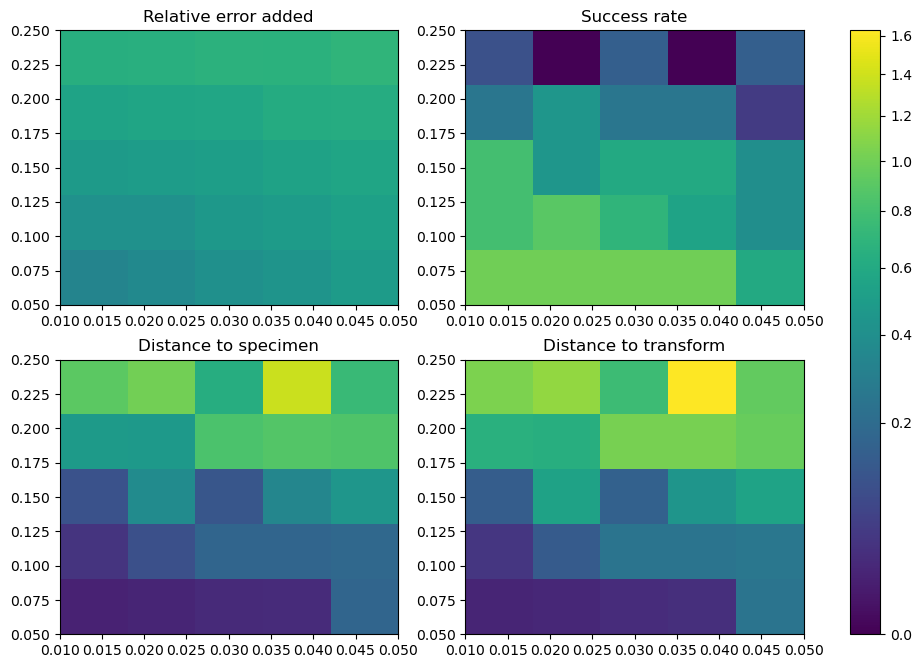

Teapot.csv with occlusion level 0.100000000000000


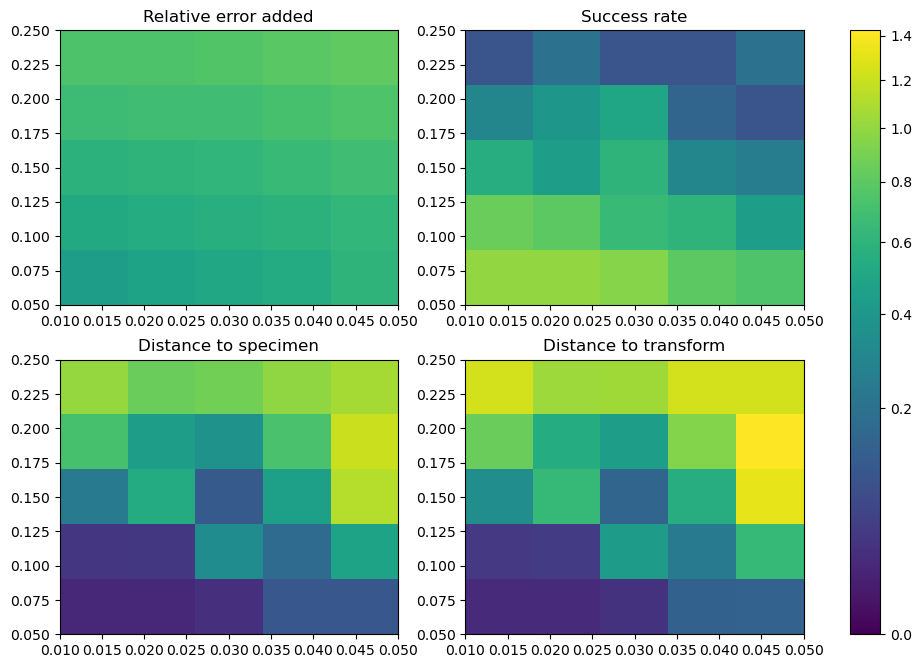

Teapot.csv with occlusion level 0.150000000000000


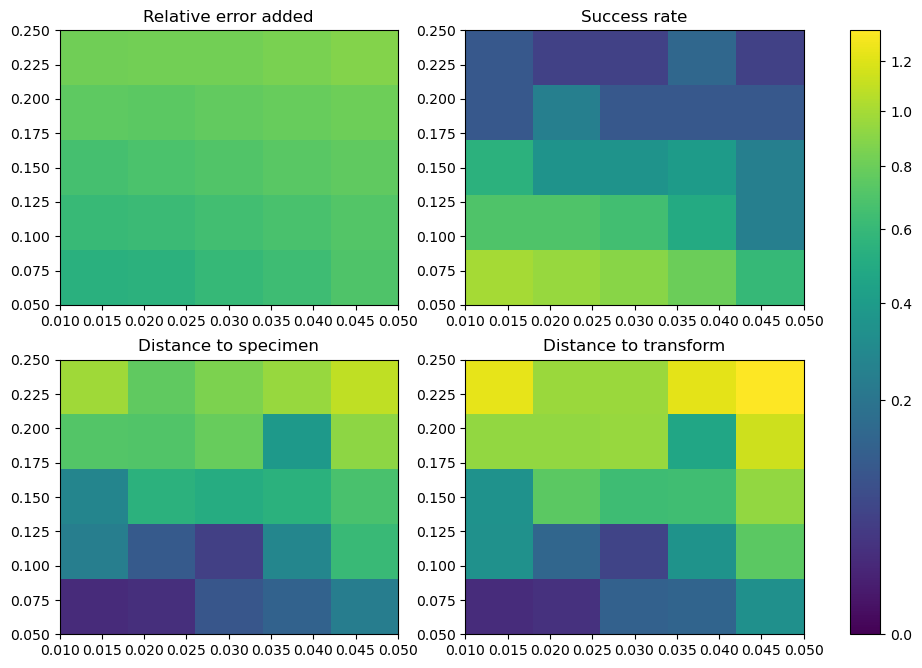

Teapot.csv with occlusion level 0.200000000000000


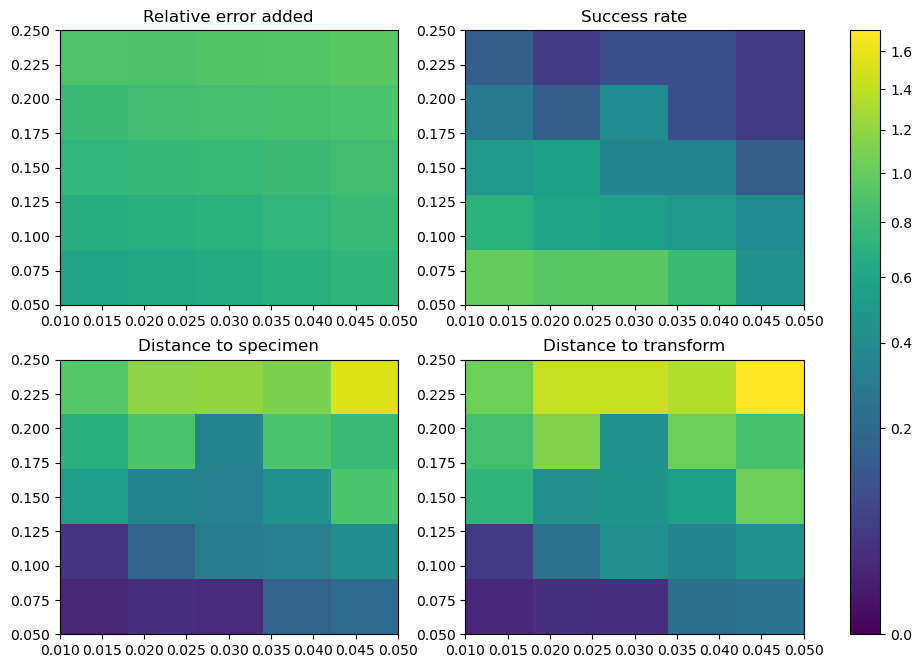

Teapot.csv with occlusion level 0.250000000000000


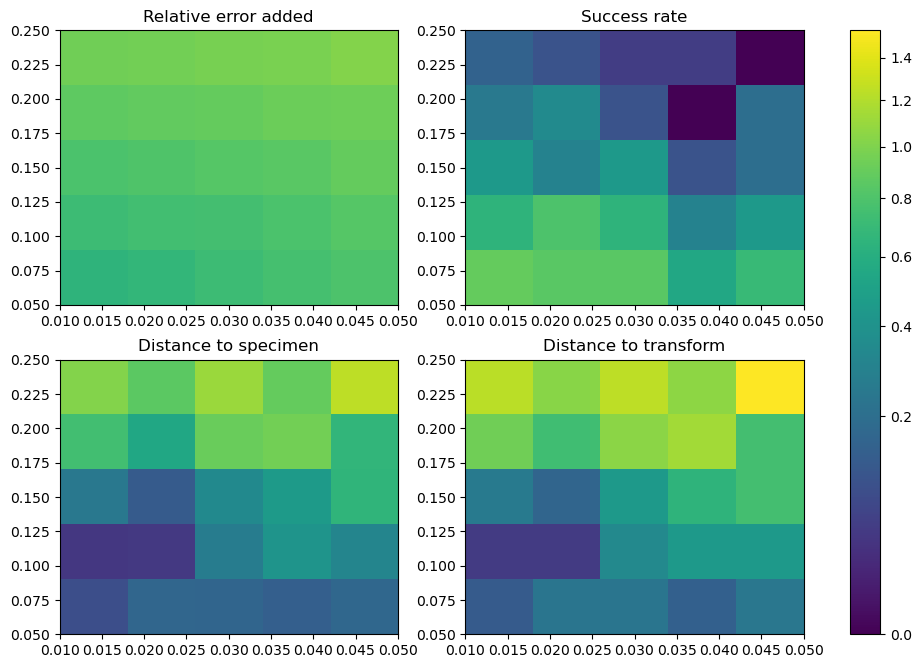

Bunny.csv with occlusion level 0.0500000000000000


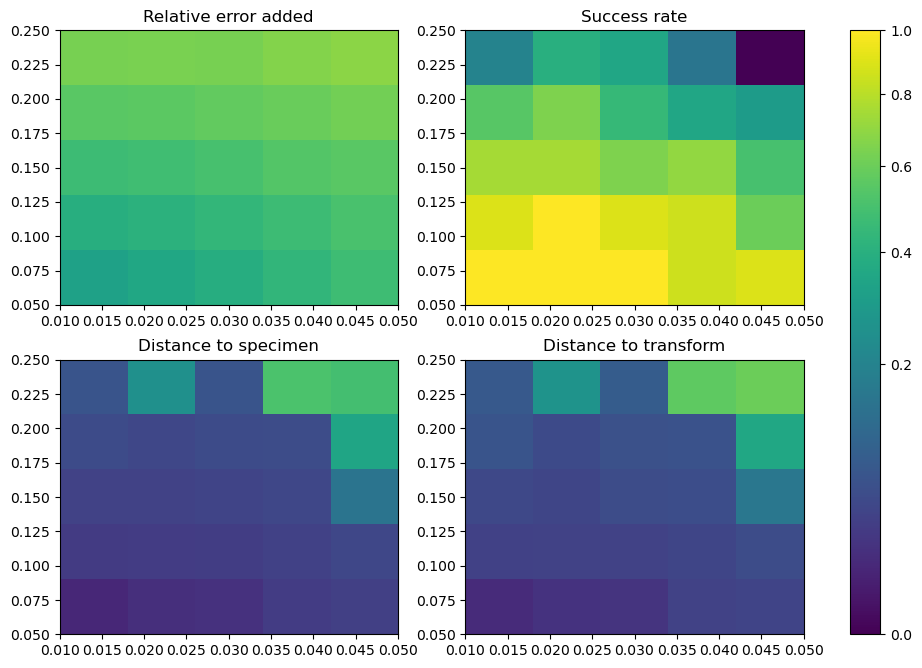

Bunny.csv with occlusion level 0.100000000000000


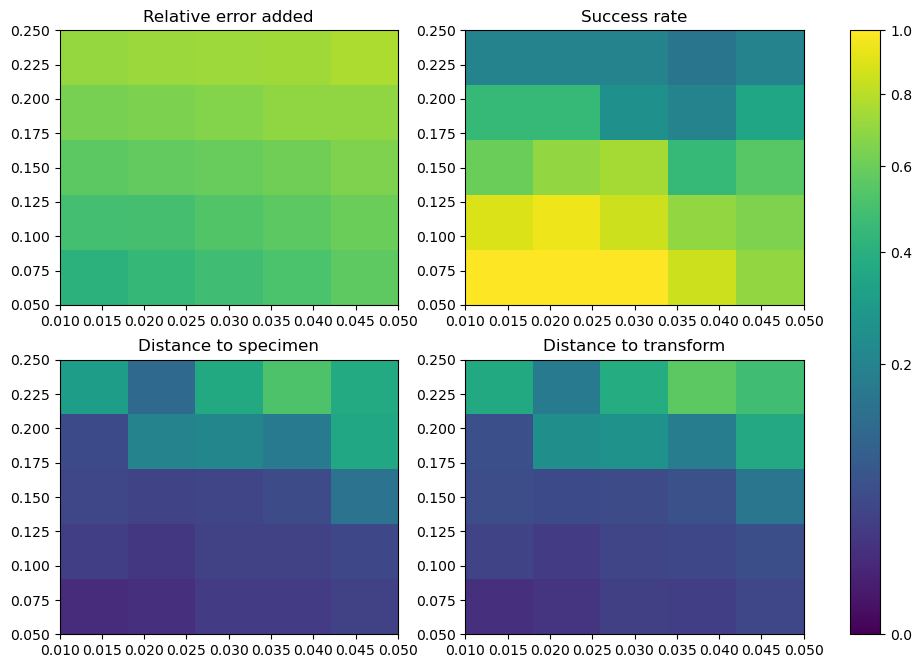

Bunny.csv with occlusion level 0.150000000000000


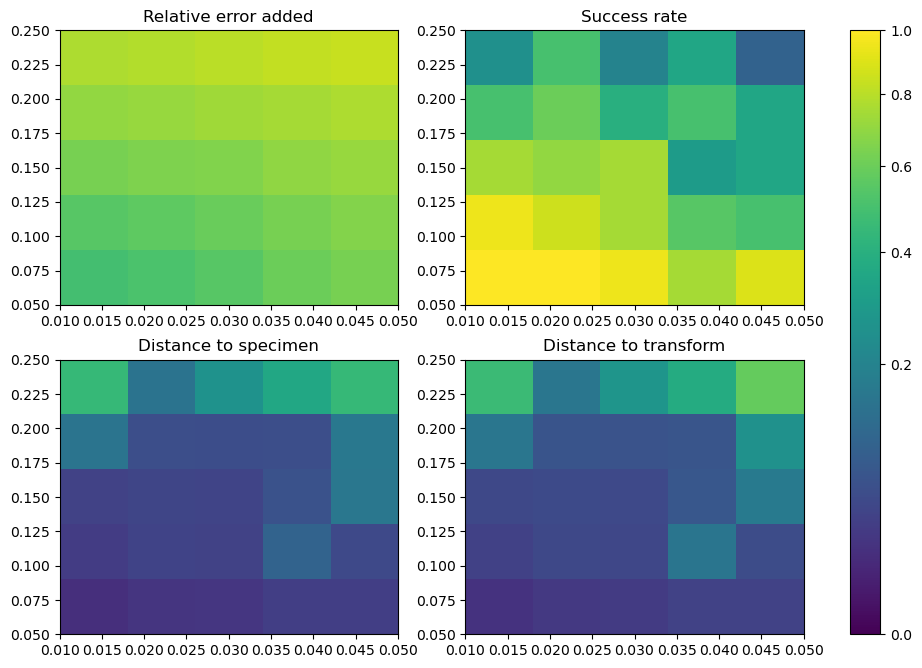

Bunny.csv with occlusion level 0.200000000000000


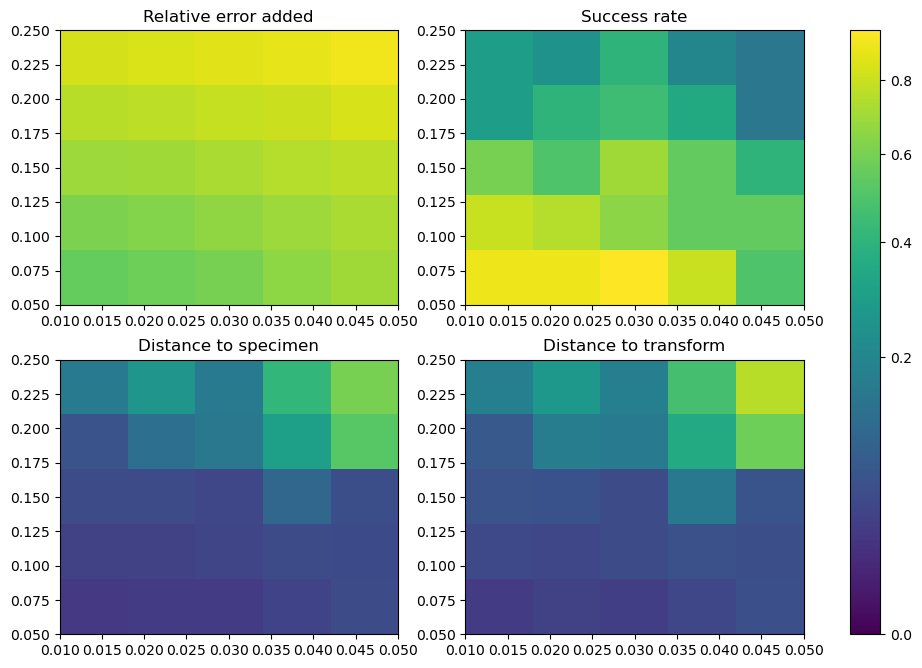

Bunny.csv with occlusion level 0.250000000000000


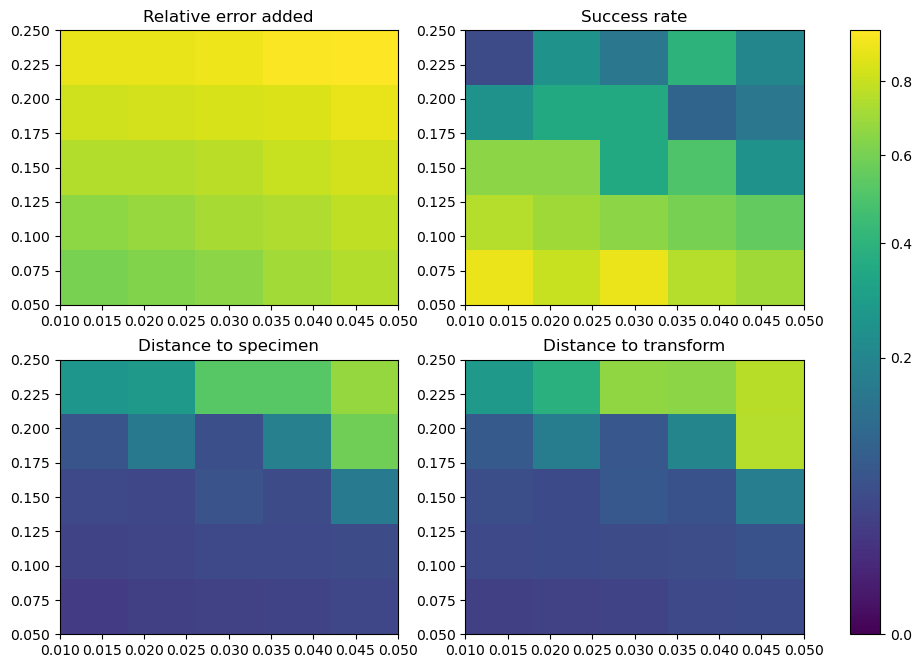

Cow.csv with occlusion level 0.0500000000000000


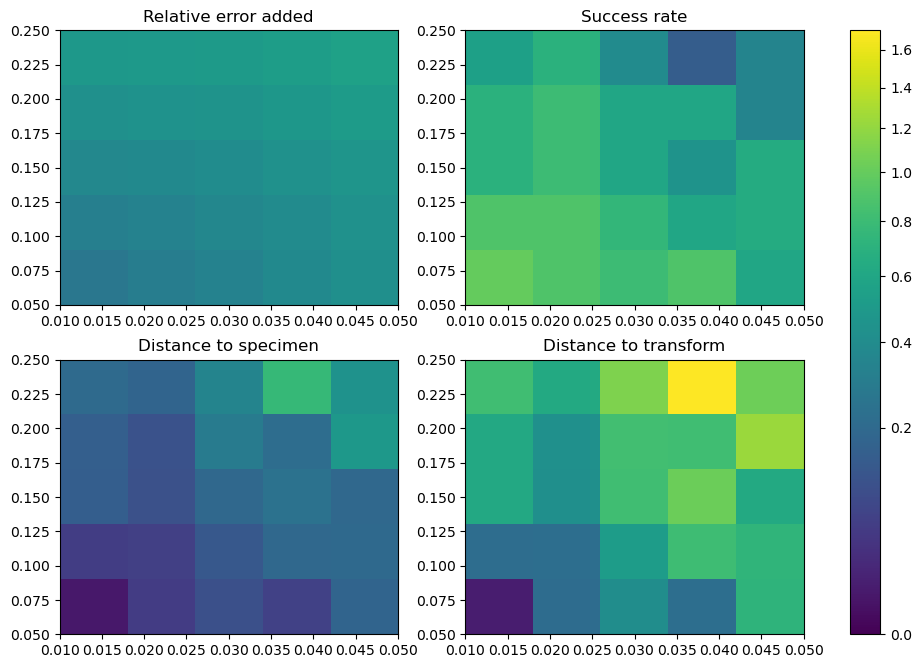

Cow.csv with occlusion level 0.100000000000000


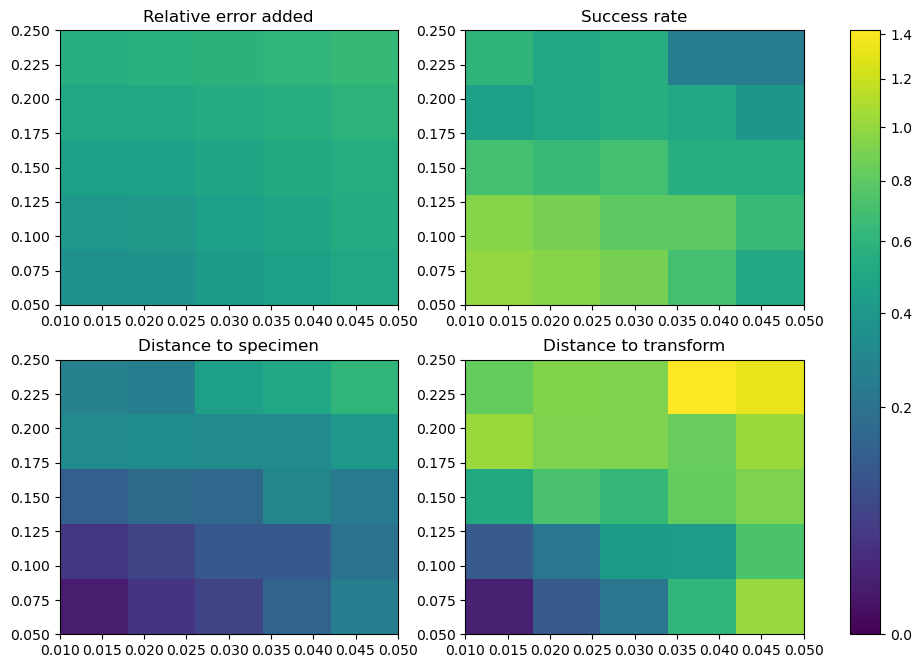

Cow.csv with occlusion level 0.150000000000000


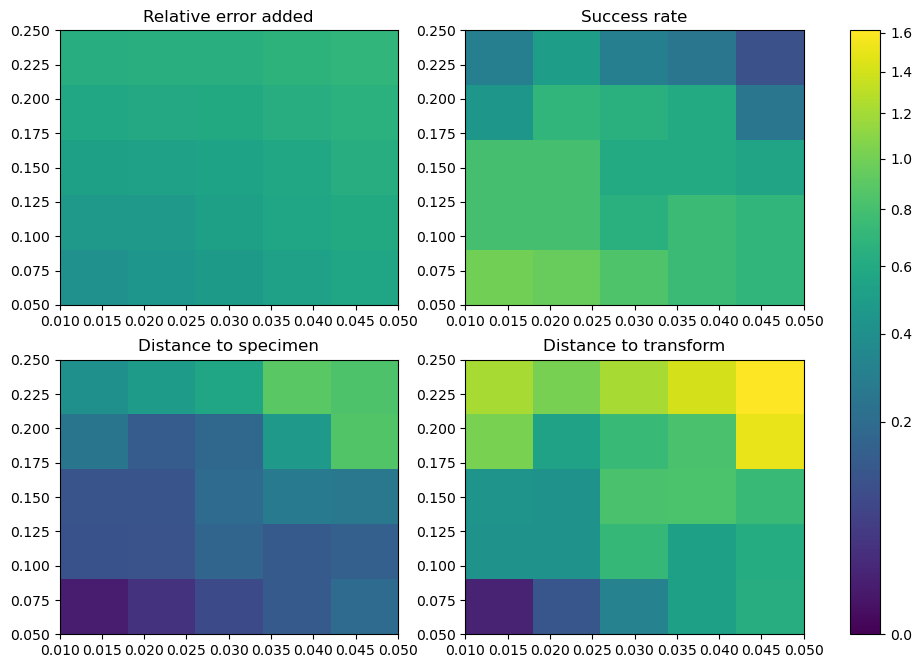

Cow.csv with occlusion level 0.200000000000000


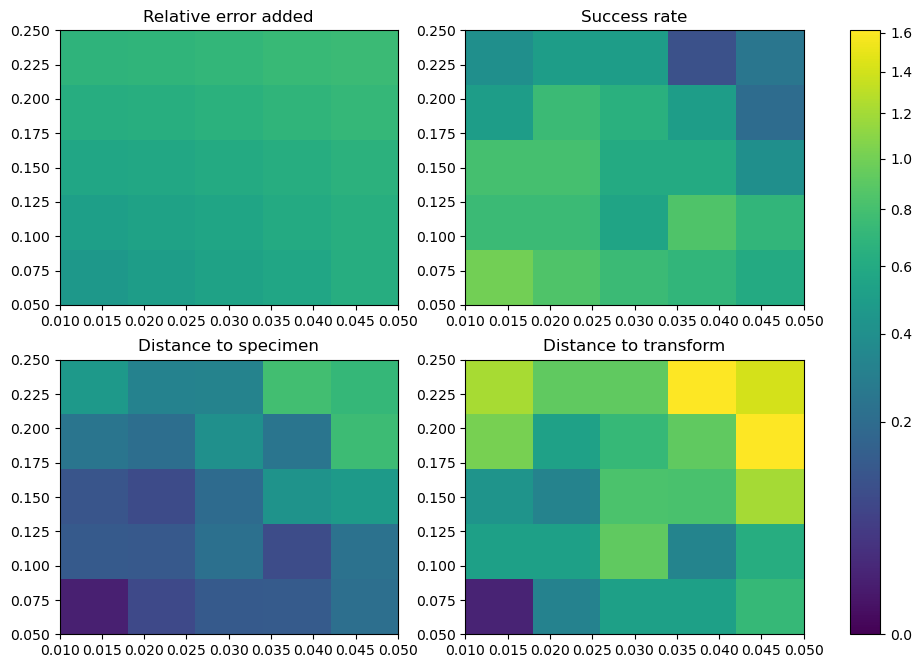

Cow.csv with occlusion level 0.250000000000000


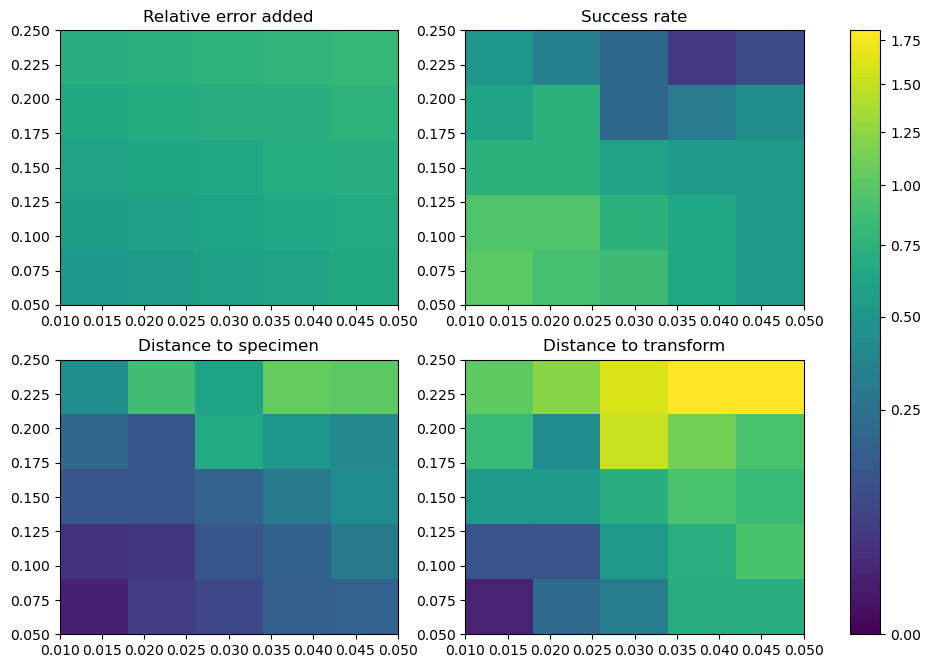

In [27]:
plot_stats_colormap(data)